In [1]:
# For interactive plots, comment the next line
%pylab inline
# For interactive plots, uncomment the next line
# %pylab ipympl
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


# Introduction
For instructions on using Jupyter notebooks, see the [README.md](../../README.md) file. 

This notebook demonstrates an example of doing pattern matching over a terrain to find similar features of interest. It computes a spatial correlation using a series of convolution operations. 

The data used for this example resides on an Amazon Web Services S3 bucket. 

# Pattern Matching Terrains

A global dataset providing bare-earth terrain heights, tiled for easy usage is provided on S3.

Source: https://registry.opendata.aws/terrain-tiles/

- Description
    - Gridded elevation tiles
- Resource type
    - S3 Bucket
- Amazon Resource Name (ARN)
    - `arn:aws:s3:::elevation-tiles-prod`
- AWS Region
    - `us-east-1`
    
We will be using this dataset to do a pattern matching analysis.

## Pattern Correlation

The Correlation Coefficient is defined as follows. We do a little bit of math to make the equation easier to implement using the existing PODPAC machinery.

$$C = \frac{E\left[(X-\bar X)(Y- \bar Y)\right]}{\sigma_x \sigma_y}$$
$$C = \frac{E\left[XY - \bar X Y - \bar Y X + \bar X \bar Y\right]}{\sigma_x \sigma_y}$$
$$C = \frac{E\left[XY\right] - \bar X \bar Y - \bar Y \bar X + \bar X \bar Y}{\sigma_x \sigma_y}$$
$$C = \frac{E\left[XY\right] - \bar X \bar Y}{\sigma_x \sigma_y}$$

where $X$ will be the section of the terrain, and $Y$ will be our pattern

In [2]:
import podpac
from podpac.datalib.terraintiles import TerrainTiles
from podpac import Coordinates, clinspace

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


In [3]:
# create terrain tiles node
node = TerrainTiles(tile_format='geotiff', zoom=8)

# create coordinates to get tiles
c = Coordinates([clinspace(43, 40, 1000), clinspace(-76, -72, 1000)], dims=['lat', 'lon'])

# evaluate node
output = node.eval(c)

INFO:podpac.datalib.terraintiles:Downloading S3 fileobj (Bucket: elevation-tiles-prod, Key: geotiff/8/73/94.tif)
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): elevation-tiles-prod.s3.amazonaws.com
INFO:podpac.datalib.terraintiles:Downloading S3 fileobj (Bucket: elevation-tiles-prod, Key: geotiff/8/74/94.tif)
INFO:podpac.datalib.terraintiles:Downloading S3 fileobj (Bucket: elevation-tiles-prod, Key: geotiff/8/75/94.tif)
INFO:podpac.datalib.terraintiles:Downloading S3 fileobj (Bucket: elevation-tiles-prod, Key: geotiff/8/76/94.tif)
INFO:podpac.datalib.terraintiles:Downloading S3 fileobj (Bucket: elevation-tiles-prod, Key: geotiff/8/73/95.tif)
INFO:podpac.datalib.terraintiles:Downloading S3 fileobj (Bucket: elevation-tiles-prod, Key: geotiff/8/74/95.tif)
INFO:podpac.datalib.terraintiles:Downloading S3 fileobj (Bucket: elevation-tiles-prod, Key: geotiff/8/75/95.tif)
INFO:podpac.datalib.terraintiles:Downloading S3 fileobj (Bucket: elevati

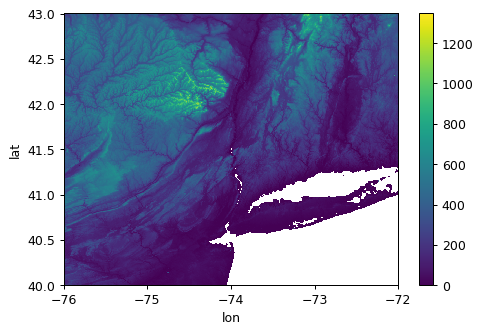

In [4]:
# plot the elevation
fig = plt.figure(dpi=90)
output.plot()
pass

# Select the pattern that we will match, and compute quantities we need for the correlation

INFO:podpac.datalib.terraintiles:Downloading S3 fileobj (Bucket: elevation-tiles-prod, Key: geotiff/8/75/94.tif)


779.4512471655329 134.67135778363607


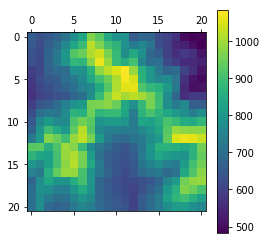

In [5]:
kernel_slice = [slice(240, 261), slice(370, 391)]
kernel_coords = Coordinates([c['lat'].coordinates[kernel_slice[0]],
                             c['lon'].coordinates[kernel_slice[1]]], ['lat', 'lon'])
kernel = node.eval(kernel_coords).data  # This is 'Y' in the equation above
kernel_mean = kernel.mean()  # This is \bar Y in the equation above
kernel_sigma = kernel.std()  # This is \sigma_y in the equation above
matshow(kernel); colorbar()
print (kernel_mean, kernel_sigma)

In [6]:
# Let's verify that the pattern correlates with itself
((kernel*kernel).mean() - kernel_mean ** 2) / kernel_sigma**2

1.0000000000000027

# Compute quantities needed for correlation from terrain

## Define the mean kernel -- we will be using this frequently

In [7]:
mean_kernel = np.ones_like(kernel)
mean_kernel /= mean_kernel.sum()

## Compute $E[XY]$ using a convolution

INFO:podpac.datalib.terraintiles:Downloading S3 fileobj (Bucket: elevation-tiles-prod, Key: geotiff/8/75/94.tif)


625680.6213151929 625680.6213151929


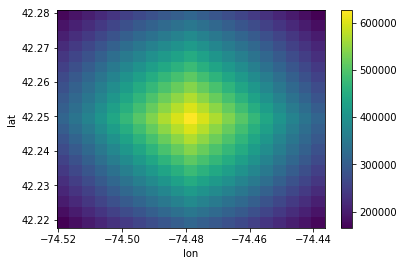

In [8]:
# Define the convolution node
E_xy = podpac.algorithm.SpatialConvolution(source=node, kernel=mean_kernel * kernel[::-1, ::-1])
# Compute the convolution for verification
E_xy_o = E_xy.eval(kernel_coords)
E_xy_o.plot()
# Sanity check the computed E[XY]
print((kernel*kernel*mean_kernel).sum(), E_xy_o[10, 10].item())

## Compute the local mean $\bar X$

INFO:podpac.datalib.terraintiles:Downloading S3 fileobj (Bucket: elevation-tiles-prod, Key: geotiff/8/75/94.tif)


779.4512471655329 779.4512471655329


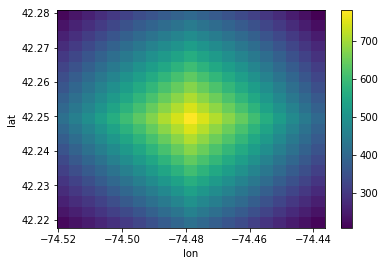

In [9]:
# Create local mean node
local_mean = podpac.algorithm.SpatialConvolution(source=node, kernel=mean_kernel)
lm_o = local_mean.eval(kernel_coords)
lm_o.plot()
print (kernel_mean, lm_o[10, 10].item())

## Compute $\sigma_x$

INFO:podpac.datalib.terraintiles:Downloading S3 fileobj (Bucket: elevation-tiles-prod, Key: geotiff/8/75/94.tif)
INFO:podpac.datalib.terraintiles:Downloading S3 fileobj (Bucket: elevation-tiles-prod, Key: geotiff/8/75/94.tif)


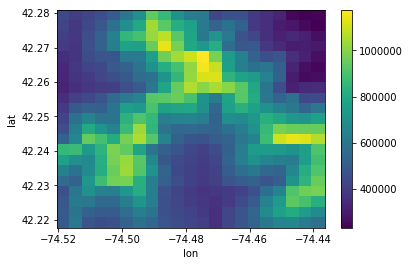

In [10]:
# Make node that squares the terrain data
squared = podpac.algorithm.Arithmetic(A=node, B=local_mean, eqn='A**2')
squared_o = squared.eval(kernel_coords)
squared_o.plot()

INFO:podpac.datalib.terraintiles:Downloading S3 fileobj (Bucket: elevation-tiles-prod, Key: geotiff/8/75/94.tif)
INFO:podpac.datalib.terraintiles:Downloading S3 fileobj (Bucket: elevation-tiles-prod, Key: geotiff/8/75/94.tif)
INFO:podpac.datalib.terraintiles:Downloading S3 fileobj (Bucket: elevation-tiles-prod, Key: geotiff/8/75/94.tif)


134.67135778363607 134.67135778363667


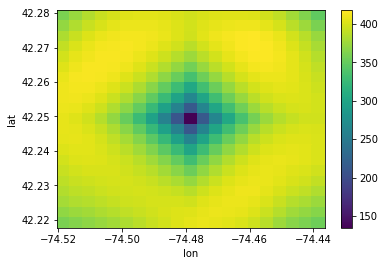

In [11]:
# Do the convolution with the mean kernel
local_var = podpac.algorithm.SpatialConvolution(source=squared, kernel=mean_kernel)
# Make a node that subtracts out the mean, and takes the squareroot to give the standard deviation
local_sigma = podpac.algorithm.Arithmetic(A=local_var, B=local_mean, 
                                         eqn='(A - B**2)**0.5')
ls_o = local_sigma.eval(kernel_coords)
ls_o.plot()
print(kernel_sigma, ls_o[10, 10].item())

## Compute the correlation coefficient with the pattern

INFO:podpac.datalib.terraintiles:Downloading S3 fileobj (Bucket: elevation-tiles-prod, Key: geotiff/8/75/94.tif)
INFO:podpac.datalib.terraintiles:Downloading S3 fileobj (Bucket: elevation-tiles-prod, Key: geotiff/8/75/94.tif)
INFO:podpac.datalib.terraintiles:Downloading S3 fileobj (Bucket: elevation-tiles-prod, Key: geotiff/8/75/94.tif)
INFO:podpac.datalib.terraintiles:Downloading S3 fileobj (Bucket: elevation-tiles-prod, Key: geotiff/8/75/94.tif)
INFO:podpac.datalib.terraintiles:Downloading S3 fileobj (Bucket: elevation-tiles-prod, Key: geotiff/8/75/94.tif)


1.0000000000000047


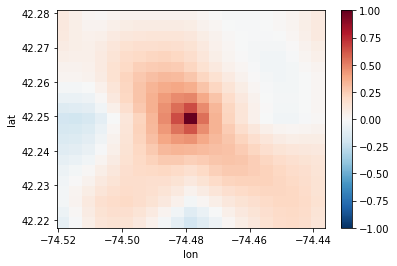

In [12]:
# Define the equation
eqn = '(A - B * {mean}) / (C * {std})'.format(mean=kernel_mean, std=kernel_sigma)
# Set up the Correlation node
correlation = podpac.algorithm.Arithmetic(A=E_xy,
                                          B=local_mean, 
                                          C=local_sigma, 
                                          eqn=eqn)
corr_o = correlation.eval(kernel_coords)
corr_o.plot()
# Check the value is 1 as expected
print(corr_o[10, 10].item())

# Examine correlation for a larger region

INFO:podpac.datalib.terraintiles:Downloading S3 fileobj (Bucket: elevation-tiles-prod, Key: geotiff/8/73/94.tif)
INFO:podpac.datalib.terraintiles:Downloading S3 fileobj (Bucket: elevation-tiles-prod, Key: geotiff/8/74/94.tif)
INFO:podpac.datalib.terraintiles:Downloading S3 fileobj (Bucket: elevation-tiles-prod, Key: geotiff/8/75/94.tif)
INFO:podpac.datalib.terraintiles:Downloading S3 fileobj (Bucket: elevation-tiles-prod, Key: geotiff/8/76/94.tif)
INFO:podpac.datalib.terraintiles:Downloading S3 fileobj (Bucket: elevation-tiles-prod, Key: geotiff/8/73/95.tif)
INFO:podpac.datalib.terraintiles:Downloading S3 fileobj (Bucket: elevation-tiles-prod, Key: geotiff/8/74/95.tif)
INFO:podpac.datalib.terraintiles:Downloading S3 fileobj (Bucket: elevation-tiles-prod, Key: geotiff/8/75/95.tif)
INFO:podpac.datalib.terraintiles:Downloading S3 fileobj (Bucket: elevation-tiles-prod, Key: geotiff/8/76/95.tif)
INFO:podpac.datalib.terraintiles:Downloading S3 fileobj (Bucket: elevation-tiles-prod, Key: geot

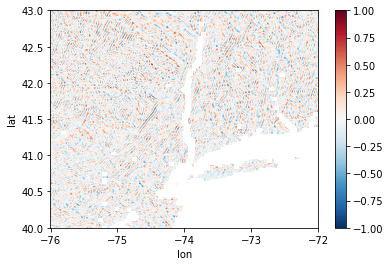

In [13]:
o = correlation.eval(c)
o.plot()

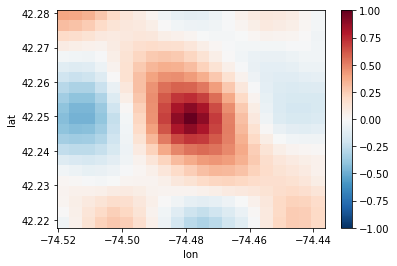

In [14]:
# Verify that the small region still looks reasonable
o[kernel_slice[0], kernel_slice[1]].plot()

# Verify that we can create a pipeline from this node (precurser to running on AWS)

INFO:podpac.datalib.terraintiles:Downloading S3 fileobj (Bucket: elevation-tiles-prod, Key: geotiff/8/75/94.tif)
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Resetting dropped connection: elevation-tiles-prod.s3.amazonaws.com
INFO:podpac.datalib.terraintiles:Downloading S3 fileobj (Bucket: elevation-tiles-prod, Key: geotiff/8/75/94.tif)
INFO:podpac.datalib.terraintiles:Downloading S3 fileobj (Bucket: elevation-tiles-prod, Key: geotiff/8/75/94.tif)
INFO:podpac.datalib.terraintiles:Downloading S3 fileobj (Bucket: elevation-tiles-prod, Key: geotiff/8/75/94.tif)
INFO:podpac.datalib.terraintiles:Downloading S3 fileobj (Bucket: elevation-tiles-prod, Key: geotiff/8/75/94.tif)


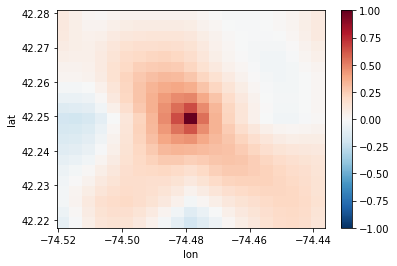

In [15]:
cp = correlation.pipeline
o = cp.eval(kernel_coords)
o.plot()